In [29]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report




pd.options.mode.chained_assignment = None  # default='warn'


pd.set_option('display.max_columns', None)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
data  = pd.read_pickle('binaryIV_results.pkl')
# Add a new column 'tightest_bounds' to identify the algorithm with the smallest bound width
bound_columns = {
    'causaloptim': 'causaloptim_bound_width',
    '2SLS': '2SLS_CI_width',
    'entropyBounds': 'entropyBounds_bound_width',
    'autobound': 'autobound_bound_width',
    'zaffalon': 'zaffalon_bound_width'
}
data['tightest_bounds'] = data[
    list(bound_columns.values())
].idxmin(axis=1).map({v: k for k, v in bound_columns.items()})

<Axes: xlabel='tightest_bounds'>

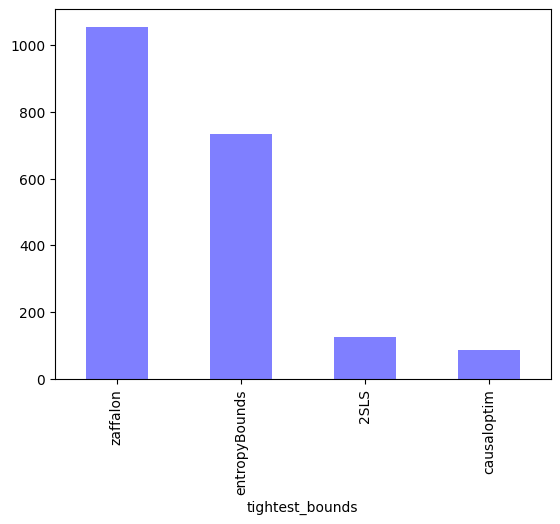

In [33]:
data['tightest_bounds'].value_counts().plot(kind='bar', alpha=0.5, color='blue')


In [18]:
def plot_smoothed_ate_vs_bounds(dataframe, algorithms=['autobound'], window=1):
    """
    Plot smoothed ATE_true and algorithm confidence intervals for multiple algorithms.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns 'ATE_true', '<algorithm>_bound_lower', '<algorithm>_bound_upper', and 'b_X_Y'.
    algorithms (list): A list of algorithm prefixes to plot (e.g., ['autobound', 'causaloptim']).
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Smoothen the data using a rolling average
    df['ATE_true_smooth'] = df['ATE_true'].rolling(window=window, center=True).mean()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')

    colors = sns.color_palette('husl', len(algorithms))

    for i, algorithm in enumerate(algorithms):
        lower_col = f'{algorithm}_bound_lower'
        upper_col = f'{algorithm}_bound_upper'

        # Handle cases where column names include 'bound' with variations
        lower_col = next((col for col in df.columns if lower_col in col), lower_col)
        upper_col = next((col for col in df.columns if upper_col in col), upper_col)

        df[f'{algorithm}_bound_lower_smooth'] = df[lower_col].rolling(window=window, center=True).mean()
        df[f'{algorithm}_bound_upper_smooth'] = df[upper_col].rolling(window=window, center=True).mean()

        sns.lineplot(data=df, x='b_X_Y', y=f'{algorithm}_bound_lower_smooth', color=colors[i], alpha=1)
        sns.lineplot(data=df, x='b_X_Y', y=f'{algorithm}_bound_upper_smooth', color=colors[i], alpha=1)

        # Add a single legend entry for the algorithm
        plt.plot([], [], color=colors[i], label=algorithm)

    # plt.axhline(0, color='red', linestyle='--', label='Zero Line')
    plt.title('Algorithms vs $ATE_{true}$ (smoothed out)')
    plt.xlabel('b_X_Y Coefficient')
    plt.ylabel('ATE Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def plot_bound_width_vs_bxy(dataframe, algorithms=['autobound'], window=1):
    """
    Plot smoothed bound width for multiple algorithms against the b_X_Y coefficient.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns '<algorithm>_bound_width' and 'b_X_Y'.
    algorithms (list): A list of algorithm prefixes to plot (e.g., ['autobound', 'causaloptim']).
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette('husl', len(algorithms))

    for i, algorithm in enumerate(algorithms):
        width_col = f'{algorithm}_bound_width'

        # Handle cases where column names include 'bound_width' with variations
        width_col = next((col for col in df.columns if width_col in col), width_col)

        df[f'{algorithm}_bound_width_smooth'] = df[width_col].rolling(window=window, center=True).mean()

        sns.lineplot(data=df, x='b_X_Y', y=f'{algorithm}_bound_width_smooth', color=colors[i], label=algorithm)

    plt.title('Bound Width vs b_X_Y Coefficient')
    plt.xlabel('b_X_Y Coefficient')
    plt.ylabel('Bound Width')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:

def plot_bound_width_vs_bz(dataframe, algorithms=['autobound'], window=1):
    """
    Plot smoothed bound width for multiple algorithms against the b_Z coefficient.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns '<algorithm>_bound_width' and 'b_Z'.
    algorithms (list): A list of algorithm prefixes to plot (e.g., ['autobound', 'causaloptim']).
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette('husl', len(algorithms))

    for i, algorithm in enumerate(algorithms):
        width_col = f'{algorithm}_bound_width'

        # Handle cases where column names include 'bound_width' with variations
        width_col = next((col for col in df.columns if width_col in col), width_col)

        df[f'{algorithm}_bound_width_smooth'] = df[width_col].rolling(window=window, center=True).mean()

        sns.lineplot(data=df, x='b_Z', y=f'{algorithm}_bound_width_smooth', color=colors[i], label=algorithm)

    plt.title('Bound Width vs b_Z Coefficient')
    plt.xlabel('b_Z Coefficient')
    plt.ylabel('Bound Width')
    plt.legend()
    plt.grid(True)
    plt.show()

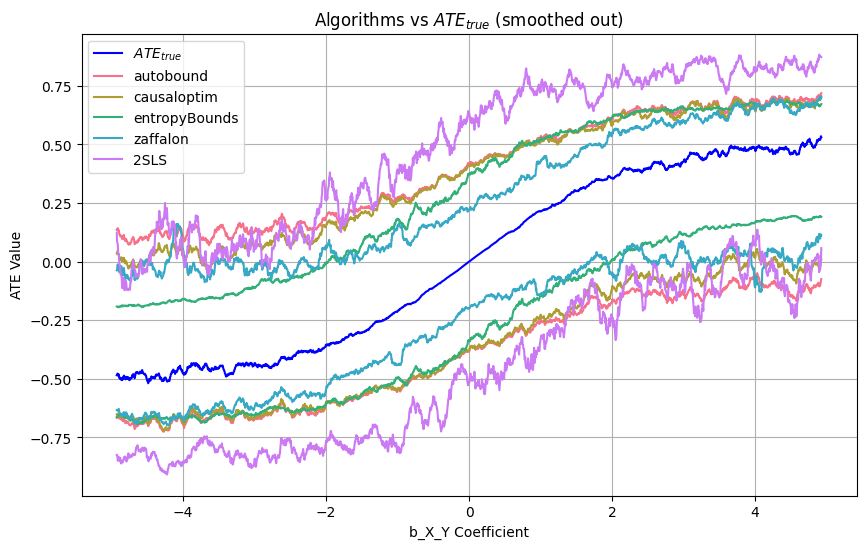

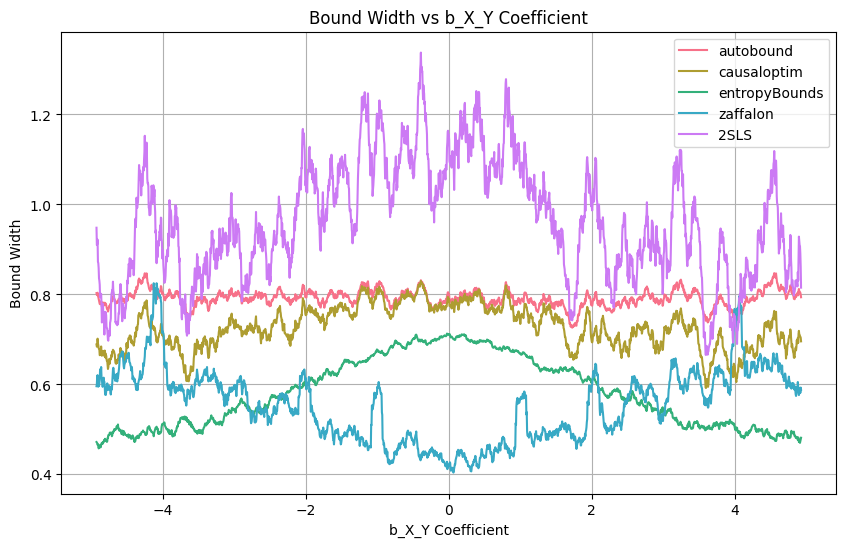

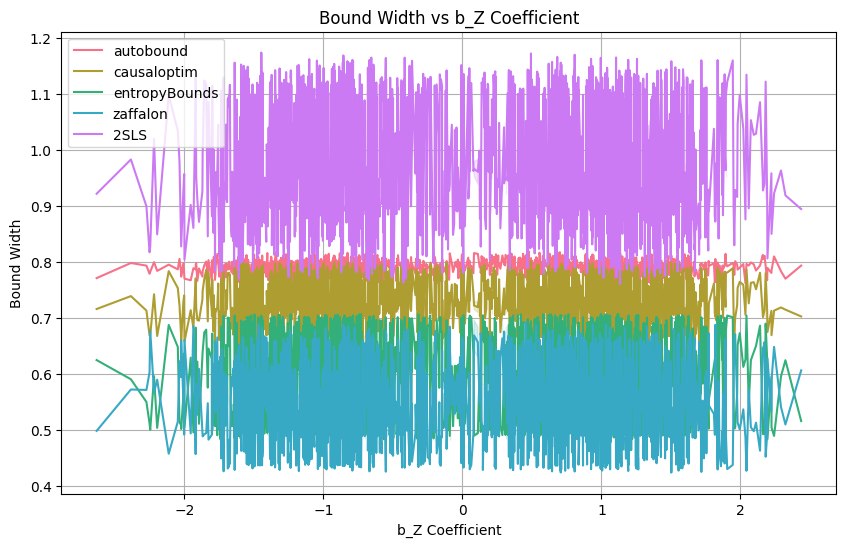

In [34]:
dataplot = data.copy()
# rename 2SLS_CI_lower to 2SLS_bound_lower and 2SLS_CI_upper to 2SLS_bound_upper
dataplot.rename(columns={'2SLS_CI_lower': '2SLS_bound_lower', '2SLS_CI_upper': '2SLS_bound_upper', '2SLS_CI_width': '2SLS_bound_width'}, inplace=True)

plot_smoothed_ate_vs_bounds(dataplot, algorithms=['autobound', 'causaloptim', 'entropyBounds', 'zaffalon', '2SLS'], window=30)
plot_bound_width_vs_bxy(dataplot, algorithms=['autobound', 'causaloptim', 'entropyBounds', 'zaffalon', '2SLS'], window=30)
plot_bound_width_vs_bz(dataplot, algorithms=['autobound', 'causaloptim', 'entropyBounds', 'zaffalon', '2SLS'], window=100)

In [28]:
data['entropyBounds_bound_width'].describe()

count    2000.000000
mean        0.999989
std         0.000010
min         0.999970
25%         0.999979
50%         0.999990
75%         1.000000
max         1.000016
Name: entropyBounds_bound_width, dtype: float64

In [35]:
# Define features and target
features = ['entropy_Y', 'entropy_X', 'entropy_Z', 'corr_X_Y', 'corr_X_Z', 'corr_Y_Z']
X = data[features]
y = data['tightest_bounds']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:

# Train the decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

         2SLS       0.52      0.60      0.56        25
  causaloptim       0.43      0.30      0.35        20
entropyBounds       0.71      0.66      0.68       157
     zaffalon       0.68      0.72      0.70       198

     accuracy                           0.67       400
    macro avg       0.58      0.57      0.57       400
 weighted avg       0.67      0.67      0.67       400



In [43]:
# Train a random forest classifier to predict 'tightest_bounds'
from sklearn.ensemble import RandomForestClassifier

# Train the random forest classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Evaluate the random forest classifier
rf_y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_y_pred))

               precision    recall  f1-score   support

         2SLS       0.67      0.72      0.69        25
  causaloptim       0.44      0.20      0.28        20
entropyBounds       0.78      0.83      0.80       157
     zaffalon       0.80      0.80      0.80       198

     accuracy                           0.78       400
    macro avg       0.67      0.64      0.64       400
 weighted avg       0.77      0.78      0.77       400



In [ ]:
# Hyperparameter tuning for the neural network using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42, max_iter=500),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and F1 score
print('Best Parameters:', grid_search.best_params_)
print('Best F1 Score:', grid_search.best_score_)

# Evaluate the best model on the test set
best_nn_clf = grid_search.best_estimator_
nn_y_pred = best_nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

In [38]:
# Run the neural network with the best parameters
best_nn_clf = MLPClassifier(
    random_state=42,
    max_iter=500,
    hidden_layer_sizes=(150, 100, 50),
    activation='relu',
    solver='adam',
    learning_rate='constant'
)

# Train the model
best_nn_clf.fit(X_train, y_train)

# Evaluate the model
nn_y_pred = best_nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

               precision    recall  f1-score   support

         2SLS       0.52      0.68      0.59        25
  causaloptim       0.50      0.35      0.41        20
entropyBounds       0.77      0.83      0.80       157
     zaffalon       0.80      0.74      0.77       198

     accuracy                           0.76       400
    macro avg       0.65      0.65      0.64       400
 weighted avg       0.76      0.76      0.75       400



Idea:
* New dataset runs through the classifier
* the bounds of the algorithm which the classifier identified as best is automatically returned

@TODO: 
punish invalid bounds to bring down the invalid rate

In [54]:
clf = best_nn_clf
# Run each datapoint through clf and save the result in a new column
data['metalearner_tightest'] = clf.predict(data[features])

# Add a column 'metalearner_bound_width' based on 'metalearner_tightest'
data['metalearner_bound_width'] = data.apply(
    lambda row: row[bound_columns[row['metalearner_tightest']]], axis=1
)

# Add a column 'metalearner_bounds_valid' based on 'metalearner_tightest'
valid_columns = {
    'causaloptim': 'causaloptim_bounds_valid',
    '2SLS': '2SLS_CI_valid',
    'entropyBounds': 'entropyBounds_bounds_valid',
    'autobound': 'autobound_bounds_valid',
    'zaffalon': 'zaffalon_bounds_valid'
}
data['metalearner_bounds_valid'] = data.apply(
    lambda row: row[valid_columns[row['metalearner_tightest']]], axis=1
)

# Display the first few rows to verify
data[['metalearner_tightest', 'metalearner_bound_width', 'metalearner_bounds_valid']].head()

### Display mean bound widths and percentage of invalid bounds
mean_bounds = data[
    ['causaloptim_bound_width', '2SLS_CI_width', 'entropyBounds_bound_width', 'autobound_bound_width', 'metalearner_bound_width']
].mean().to_frame(name='Mean Bound Width').T

metalearner_invalid_rate = data[data['metalearner_bounds_valid'] == False].shape[0] / data.shape[0]
print(f"Metalearner Invalid Rate: {metalearner_invalid_rate:.2%}")
causaloptim_invalid_rate = data[data['causaloptim_bounds_valid'] == False].shape[0] / data.shape[0]
print(f"Causaloptim Invalid Rate: {causaloptim_invalid_rate:.2%}")
SLS_invalid_rate = data[data['2SLS_CI_valid'] == False].shape[0] / data.shape[0]
print(f"2SLS Invalid Rate: {SLS_invalid_rate:.2%}")
autobound_invalid_rate = data[data['autobound_bounds_valid'] == False].shape[0] / data.shape[0]
print(f"Autobound Invalid Rate: {autobound_invalid_rate:.2%}")
entropyBounds_invalid_rate = data[data['entropyBounds_bounds_valid'] == False].shape[0] / data.shape[0]
print(f"Entropy Bounds Invalid Rate: {entropyBounds_invalid_rate:.2%}")
zaffalon_invalid_rate = data[data['zaffalon_bounds_valid'] == False].shape[0] / data.shape[0]
print(f"Zaffalon Invalid Rate: {zaffalon_invalid_rate:.2%}")
mean_bounds

Metalearner Invalid Rate: 1.60%
Causaloptim Invalid Rate: 0.25%
2SLS Invalid Rate: 0.80%
Autobound Invalid Rate: 0.00%
Entropy Bounds Invalid Rate: 0.90%
Zaffalon Invalid Rate: 0.90%


,causaloptim_bound_width,2SLS_CI_width,entropyBounds_bound_width,autobound_bound_width,metalearner_bound_width
Mean Bound Width,0.726601,0.962296,0.578968,0.791446,0.486802
